In [1]:
pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
anyio                        4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       4.1.0
Brotli                       1.0.9
cachetools                   5.3.3
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
comm                         0.2.1
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.0
executing                    0.8.3
fastjsonschema               2.16.2
f

## 1. Importing libraries and Dataset Configuration

In [28]:
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import re
from datetime import datetime, timedelta
from collections import defaultdict, deque
import pickle

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print('gpu ', gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

gpu  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


#### Dataset Pipelining

In [10]:
df = pd.read_csv('dataset5.csv')
df.head()

,Sentences,Label_Task,Estimated_hours
0,Berkoordinasi dengan Dinas Perhubungan setempa...,Analisis Kebutuhan,20
1,Melakukan analisis pasar untuk mengidentifikas...,Analisis Kebutuhan,20
2,Melakukan analisis pasar untuk mengidentifikas...,Analisis Kebutuhan,20
3,Melakukan kunjungan lapangan ke beberapa petan...,Analisis Kebutuhan,20
4,Melakukan observasi langsung di rumah sakit un...,Analisis Kebutuhan,20


#### Dataset Exploration and Cleaning

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentences        2300 non-null   object
 1   Label_Task       2300 non-null   object
 2   Estimated_hours  2300 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 54.0+ KB


In [12]:
print("Jumlah duplikasi: ",df.duplicated().sum())
df.describe()

Jumlah duplikasi:  22


,Estimated_hours
count,2300.000000
mean,24.782609
std,9.266048
min,10.000000
25%,20.000000
50%,20.000000
75%,30.000000
max,50.000000


In [13]:
df = df.drop_duplicates()
print("Jumlah duplikasi: ",df.duplicated().sum())

Jumlah duplikasi:  0


In [14]:
# Drop rows where 'Sentences' column has NaN values
df = df.dropna(subset=['Sentences'])

# Calculate the counts of each label
label_counts = df['Label_Task'].value_counts()
print(label_counts.head(26))

Label_Task
Integrasi API                         100
Pengumpulan Data                      100
Pengujian Fungsionalitas              100
Dokumentasi                           100
Backend Development                   100
Presentasi dan Demo                   100
Pengembangan API                      100
Visualisasi Data                      100
Evaluasi Model                        100
Perancangan Basis Data                100
Pengujian dan Perbaikan               100
Deployment                            100
Pengujian Sistem                      100
Pengujian Unit                        100
Pengujian Integrasi                    99
Pengujian User Acceptance (UAT)        99
Integrasi Model                        98
Frontend Development                   98
Desain UI/UX                           98
Analisis Kebutuhan                     98
Pembersihan dan Preprocessing Data     97
Implementasi Fitur                     97
Pembuatan Basis Data                   94
Name: count, dtype: int

## 2. Preprocessing Dataset

#### Splitting Data

In [15]:
# Filter labels with at least 45 sentences
valid_labels = label_counts[label_counts >= 80].index

filtered_df = df[df['Label_Task'].isin(valid_labels)]
num_classes = filtered_df['Label_Task'].nunique()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels to integers
filtered_df.loc[:, 'Label_Task'] = label_encoder.fit_transform(filtered_df['Label_Task'])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(filtered_df, train_size=0.8,stratify=filtered_df['Label_Task'], random_state=42, shuffle=True)

# Extract sentences and labels for training
train_sentences = train_df['Sentences'].tolist()
train_labels = train_df['Label_Task'].tolist()

# Extract sentences and labels for validation
val_sentences = val_df['Sentences'].tolist()
val_labels = val_df['Label_Task'].tolist()

# Check the results
print(f"Number of training examples: {len(train_sentences)}")
print(f"Number of validation examples: {len(val_sentences)}")

# print('First 5 train sentences:\n', train_sentences[:5])
# print('First 5 train labels:\n', train_labels[:5])

# print('First 5 val sentences:\n', val_sentences[:5])
# print('First 5 val labels:\n', val_labels[:5])

Number of training examples: 1822
Number of validation examples: 456


In [16]:
print('val labels:',num_classes)

val labels: 23


#### Lowercase Augmentation

In [17]:
def lowercase_augmentation(sentences):
    augmented_sentences = []
    for sentence in sentences:
        lowercase_sentence = sentence.lower()
        augmented_sentences.append(lowercase_sentence)
    return augmented_sentences

#### Tokenizer

In [18]:
vocab_size = 100000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
# Melakukan data augmentasi pada data latih dengan mengubah semua kalimat menjadi huruf kecil
train_sentences = lowercase_augmentation(train_sentences)
val_sentences = lowercase_augmentation(val_sentences)

# Tokenize the training sentences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Create sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Convert labels to one-hot encoding if using categorical_crossentropy
# Ensure labels are converted to one-hot encoding only once
if len(train_labels.shape) == 1:
    train_labels = to_categorical(train_labels, num_classes)
if len(val_labels.shape) == 1:
    val_labels = to_categorical(val_labels, num_classes)

# Check the shape of the padded sequences and labels
print(f"Training data shape: {train_padded.shape}")
print(f"Validation data shape: {val_padded.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training data shape: (1822, 100)
Validation data shape: (456, 100)
Training labels shape: (1822, 23)
Validation labels shape: (456, 23)


## 3. Model Building and Training

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

2024-06-08 09:44:27.357663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 09:44:29.671510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 51333 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           1600000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 23)                1495      
                                                        

#### Model Training

In [21]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Define the ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',  # Path where the model weights will be saved
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save the best model only
    save_weights_only=False,   # Save the entire model (including architecture)
    mode='min',                # Mode for monitoring ('min' for loss, 'max' for accuracy)
    verbose=1                  # Verbosity mode, 1 for progress updates
)

# Define other callbacks (optional)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

callback_list = [
    reduce_lr_callback,
    early_stopping_callback
]

In [22]:
batch_size = 64
num_epochs = 40
history = model.fit(train_padded, 
                    train_labels, 
                    epochs=num_epochs, 
                    # batch_size=batch_size, 
                    validation_data=(val_padded, val_labels), 
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/40


2024-06-08 09:44:39.587891: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2024-06-08 09:44:41.539816: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-08 09:44:41.540694: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-08 09:44:41.540715: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-06-08 09:44:41.541223: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-08 09:44:41.541284: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-06-08 09:44:41.701090: I tensorflow/stream_executor/cuda/c

57/57 [==============================] - 11s 54ms/step - loss: 3.2015 - accuracy: 0.0477 - val_loss: 3.1776 - val_accuracy: 0.1053 - lr: 0.0010
Epoch 2/40
57/57 [==============================] - 2s 43ms/step - loss: 3.1450 - accuracy: 0.1015 - val_loss: 3.0916 - val_accuracy: 0.2259 - lr: 0.0010
Epoch 3/40
57/57 [==============================] - 2s 44ms/step - loss: 2.9226 - accuracy: 0.2091 - val_loss: 2.6696 - val_accuracy: 0.3531 - lr: 0.0010
Epoch 4/40
57/57 [==============================] - 2s 43ms/step - loss: 2.3273 - accuracy: 0.3513 - val_loss: 1.8658 - val_accuracy: 0.5877 - lr: 0.0010
Epoch 5/40
57/57 [==============================] - 3s 47ms/step - loss: 1.7103 - accuracy: 0.5170 - val_loss: 1.3269 - val_accuracy: 0.7390 - lr: 0.0010
Epoch 6/40
57/57 [==============================] - 3s 56ms/step - loss: 1.2950 - accuracy: 0.6701 - val_loss: 1.0268 - val_accuracy: 0.8158 - lr: 0.0010
Epoch 7/40
57/57 [==============================] - 2s 44ms/step - loss: 1.0240 - accu

#### Model Predict

In [27]:
# Example input sentences
new_sentences = ["Melakukan analisis pasar untuk mengidentifikasi target pelanggan potensial website, serta preferensi mereka dalam berbelanja online.", 
                 "Mengamankan akses ke platform cloud dan aplikasi web dengan menerapkan autentikasi dan otorisasi yang sesuai."]

new_sentences = ["buat front end", 
                 "analisis keperluan user"]
# Tokenize the sentences
sequences = tokenizer.texts_to_sequences(new_sentences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
# Make predictions
predictions = model.predict(padded_sequences)
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
print("Predicted class indices:", predicted_classes)
# Convert numeric labels back to original string labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)
print("Predicted class labels:", predicted_labels)

1/1 [==============================] - 0s 128ms/step
Predicted class indices: [10 10]
Predicted class labels: ['Pembersihan dan Preprocessing Data' 'Pembersihan dan Preprocessing Data']


#### Model, Tokenizer, and Label Encoder Save

In [26]:
model.save("text_classify.h5")

In [29]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 4. Evaluation

15/15 [==============================] - 0s 10ms/step
                                    precision    recall  f1-score   support

                Analisis Kebutuhan       0.92      0.63      0.75        19
               Backend Development       1.00      0.95      0.97        20
                        Deployment       1.00      1.00      1.00        20
                      Desain UI/UX       1.00      1.00      1.00        20
                       Dokumentasi       0.85      0.85      0.85        20
                    Evaluasi Model       0.87      1.00      0.93        20
              Frontend Development       0.95      0.95      0.95        20
                Implementasi Fitur       0.78      0.95      0.86        19
                     Integrasi API       0.76      0.80      0.78        20
                   Integrasi Model       1.00      0.95      0.97        20
Pembersihan dan Preprocessing Data       0.94      0.84      0.89        19
              Pembuatan Basis Dat

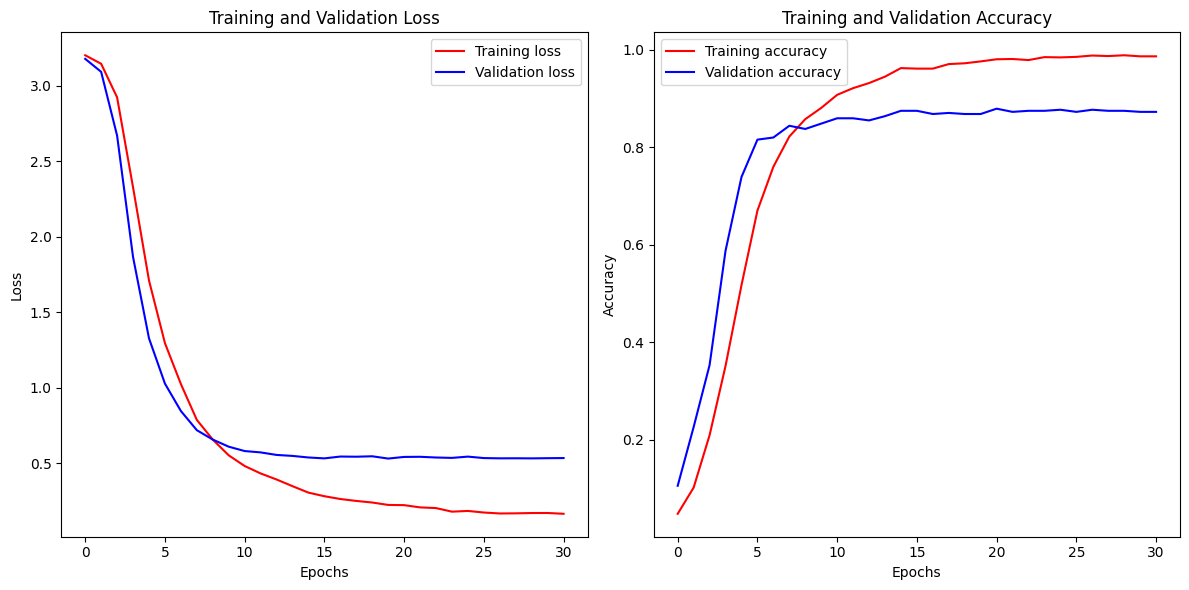

In [25]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Predict on validation data
predictions = model.predict(val_padded)
y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Ensure the number of classes match
unique_labels = np.unique(y_true)
target_names = [label_encoder.inverse_transform([i])[0] for i in unique_labels]

# Generate classification report
report = classification_report(y_true, y_pred, target_names=target_names, zero_division=0)

# Print classification report
print(report)

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
